In [1]:
import numpy as np

def simulate_gbm_fx(S0, mu, sigma, T, dt, Npaths):
    steps = int(T/dt)
    paths = np.zeros((steps, Npaths))
    paths[0] = S0
    for t in range(1, steps):
        Z = np.random.standard_normal(Npaths)
        paths[t] = paths[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return paths
'''

# src/simulation/gbm_fx.py
import numpy as np
import pandas as pd

def calibrate_gbm_params(fx_spot_path):
    log_returns = np.log(fx_spot_path / fx_spot_path.shift(1)).dropna()
    mu = log_returns.mean() * 252  # Annualized drift
    sigma = log_returns.std() * np.sqrt(252)  # Annualized vol
    return mu, sigma

def simulate_gbm_fx(fx_csv, T=1, dt=1/252, Npaths=1000):
    # Load dataset
    df = pd.read_csv(fx_csv, parse_dates=['Date']).set_index('Date')
    fx_spot = df['USD/INR']
    mu, sigma = calibrate_gbm_params(fx_spot)
    S0 = fx_spot.iloc[-1]

    Nsteps = int(T / dt)
    paths = np.zeros((Nsteps, Npaths))
    paths[0] = S0

    for t in range(1, Nsteps):
        z = np.random.normal(size=Npaths)
        paths[t] = paths[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)

    return paths
'''

"\n\n# src/simulation/gbm_fx.py\nimport numpy as np\nimport pandas as pd\n\ndef calibrate_gbm_params(fx_spot_path):\n    log_returns = np.log(fx_spot_path / fx_spot_path.shift(1)).dropna()\n    mu = log_returns.mean() * 252  # Annualized drift\n    sigma = log_returns.std() * np.sqrt(252)  # Annualized vol\n    return mu, sigma\n\ndef simulate_gbm_fx(fx_csv, T=1, dt=1/252, Npaths=1000):\n    # Load dataset\n    df = pd.read_csv(fx_csv, parse_dates=['Date']).set_index('Date')\n    fx_spot = df['USD/INR']\n    mu, sigma = calibrate_gbm_params(fx_spot)\n    S0 = fx_spot.iloc[-1]\n\n    Nsteps = int(T / dt)\n    paths = np.zeros((Nsteps, Npaths))\n    paths[0] = S0\n\n    for t in range(1, Nsteps):\n        z = np.random.normal(size=Npaths)\n        paths[t] = paths[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)\n\n    return paths\n"

In [2]:
import numpy as np

def simulate_cir_lambda(lambda0, kappa, theta, sigma, T, dt, Npaths):
    steps = int(T/dt)
    lambdas = np.zeros((steps, Npaths))
    lambdas[0] = lambda0
    for t in range(1, steps):
        Z = np.random.standard_normal(Npaths)
        lambdas[t] = lambdas[t-1] + kappa*(theta - lambdas[t-1])*dt + sigma*np.sqrt(np.maximum(lambdas[t-1], 0))*np.sqrt(dt)*Z
        lambdas[t] = np.maximum(lambdas[t], 0)  # No negative intensities
    return lambdas
'''

# src/simulation/cir_hazard.py
import numpy as np
import pandas as pd

def calibrate_cir_params(cds_df, recovery=0.4):
    spreads = cds_df['USD 5Y CDS'] / 10000  # Convert bps to decimal
    hazard = spreads / (1 - recovery)
    d_lambda = hazard.diff().dropna()
    kappa = 0.3  # Example value, more advanced calibration possible
    theta = hazard.mean()
    sigma = d_lambda.std() * np.sqrt(252)
    lambda0 = hazard.iloc[-1]
    return lambda0, kappa, theta, sigma

def simulate_cir_lambda(cds_csv, T=1, dt=1/252, Npaths=1000):
    df = pd.read_csv(cds_csv, parse_dates=['Date']).set_index('Date')
    lambda0, kappa, theta, sigma = calibrate_cir_params(df)

    Nsteps = int(T / dt)
    hazard = np.zeros((Nsteps, Npaths))
    hazard[0] = lambda0

    for t in range(1, Nsteps):
        z = np.random.normal(size=Npaths)
        hazard[t] = hazard[t-1] + kappa*(theta - hazard[t-1])*dt + sigma*np.sqrt(hazard[t-1])*np.sqrt(dt)*z
        hazard[t] = np.maximum(hazard[t], 0)

    return hazard
'''

"\n\n# src/simulation/cir_hazard.py\nimport numpy as np\nimport pandas as pd\n\ndef calibrate_cir_params(cds_df, recovery=0.4):\n    spreads = cds_df['USD 5Y CDS'] / 10000  # Convert bps to decimal\n    hazard = spreads / (1 - recovery)\n    d_lambda = hazard.diff().dropna()\n    kappa = 0.3  # Example value, more advanced calibration possible\n    theta = hazard.mean()\n    sigma = d_lambda.std() * np.sqrt(252)\n    lambda0 = hazard.iloc[-1]\n    return lambda0, kappa, theta, sigma\n\ndef simulate_cir_lambda(cds_csv, T=1, dt=1/252, Npaths=1000):\n    df = pd.read_csv(cds_csv, parse_dates=['Date']).set_index('Date')\n    lambda0, kappa, theta, sigma = calibrate_cir_params(df)\n\n    Nsteps = int(T / dt)\n    hazard = np.zeros((Nsteps, Npaths))\n    hazard[0] = lambda0\n\n    for t in range(1, Nsteps):\n        z = np.random.normal(size=Npaths)\n        hazard[t] = hazard[t-1] + kappa*(theta - hazard[t-1])*dt + sigma*np.sqrt(hazard[t-1])*np.sqrt(dt)*z\n        hazard[t] = np.maximum(haz

In [3]:
import numpy as np

def simulate_hull_white(r0, kappa, theta, sigma, T, dt, Npaths):
    steps = int(T/dt)
    rates = np.zeros((steps, Npaths))
    rates[0] = r0
    for t in range(1, steps):
        Z = np.random.standard_normal(Npaths)
        dr = kappa * (theta - rates[t-1]) * dt + sigma * np.sqrt(dt) * Z
        rates[t] = rates[t-1] + dr
    return rates
'''
# src/simulation/hull_white_ir.py
import numpy as np
import pandas as pd

def calibrate_hull_white_params(yield_curve_df, tenor='1Y'):
    short_rates = yield_curve_df[tenor].dropna()
    dr = short_rates.diff().dropna()
    kappa = 0.1  # Could do more advanced calibration here
    theta = short_rates.mean()
    sigma = dr.std() * np.sqrt(252)
    r0 = short_rates.iloc[-1]
    return r0, kappa, theta, sigma

def simulate_hull_white(yield_csv, T=1, dt=1/252, Npaths=1000):
    df = pd.read_csv(yield_csv, parse_dates=['Date']).set_index('Date')
    r0, kappa, theta, sigma = calibrate_hull_white_params(df)

    Nsteps = int(T / dt)
    rates = np.zeros((Nsteps, Npaths))
    rates[0] = r0

    for t in range(1, Nsteps):
        z = np.random.normal(size=Npaths)
        rates[t] = rates[t-1] + kappa*(theta - rates[t-1])*dt + sigma*np.sqrt(dt)*z

    return rates
'''

"\n# src/simulation/hull_white_ir.py\nimport numpy as np\nimport pandas as pd\n\ndef calibrate_hull_white_params(yield_curve_df, tenor='1Y'):\n    short_rates = yield_curve_df[tenor].dropna()\n    dr = short_rates.diff().dropna()\n    kappa = 0.1  # Could do more advanced calibration here\n    theta = short_rates.mean()\n    sigma = dr.std() * np.sqrt(252)\n    r0 = short_rates.iloc[-1]\n    return r0, kappa, theta, sigma\n\ndef simulate_hull_white(yield_csv, T=1, dt=1/252, Npaths=1000):\n    df = pd.read_csv(yield_csv, parse_dates=['Date']).set_index('Date')\n    r0, kappa, theta, sigma = calibrate_hull_white_params(df)\n\n    Nsteps = int(T / dt)\n    rates = np.zeros((Nsteps, Npaths))\n    rates[0] = r0\n\n    for t in range(1, Nsteps):\n        z = np.random.normal(size=Npaths)\n        rates[t] = rates[t-1] + kappa*(theta - rates[t-1])*dt + sigma*np.sqrt(dt)*z\n\n    return rates\n"

In [4]:
import numpy as np

def correlate_risk_factors(paths_list, corr_matrix):
    """
    paths_list: list of (steps, Npaths) arrays
    corr_matrix: user-defined correlation matrix
    """
    L = np.linalg.cholesky(corr_matrix)
    steps, Npaths = paths_list[0].shape
    correlated = []
    for t in range(steps):
        Z = np.random.standard_normal((corr_matrix.shape[0], Npaths))
        Z_corr = L @ Z
        for i, path in enumerate(paths_list):
            path[t] = path[t-1] + Z_corr[i]  # update with correlated shock
            correlated.append(path)
    return correlated


In [5]:
import numpy as np

def calculate_cva(EPE, hazard_rates, LGD, discount_factors, dt):
    dPD = hazard_rates * dt
    CVA = np.sum(EPE * dPD * discount_factors) * LGD
    return CVA

def discount_curve(rates, dt):
    steps = rates.shape[0]
    times = np.linspace(0, steps*dt, steps)
    return np.exp(-rates.mean(axis=1) * times)


In [6]:
import numpy as np

def calculate_exposure(MtM, collateral_threshold=0):
    """
    Exposure after collateral: max(MtM - Collateral, 0)
    """
    collateral = np.maximum(MtM - collateral_threshold, 0)
    exposure = np.maximum(MtM - collateral, 0)
    return exposure

def expected_positive_exposure(exposures):
    return exposures.mean(axis=1)

def apply_wrong_way_risk(hazard_rates, exposures, correlation=0.5):
    """
    Simple WWR: hazard rate increases with exposure
    """
    adjusted_hazard = hazard_rates * (1 + correlation * (exposures / np.max(exposures)))
    return adjusted_hazard


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_stacked_lstm(timesteps, features, units=100):
    model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(timesteps, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

    model.compile(optimizer='adam', loss='mse')
    return model


In [8]:
import numpy as np

def backtest(predicted, actual):
    mse = np.mean((predicted - actual)**2)
    return mse

def stress_test(exposures, shock_factor):
    """
    Apply a stress scenario (e.g., shock FX by +10%)
    """
    shocked = exposures * (1 + shock_factor)
    return shocked


In [9]:
'''
fx_paths = simulate_gbm_fx('fx_spot.csv')
ir_paths = simulate_hull_white('yield_curves.csv')
hazard_paths = simulate_cir_lambda('cds_spreads.csv')

# Feed these into Portfolio, Exposure, CVA, LSTM...


TypeError: simulate_gbm_fx() missing 5 required positional arguments: 'mu', 'sigma', 'T', 'dt', and 'Npaths'

In [10]:
import numpy as np

class Portfolio:
    def __init__(self, trades):
        self.trades = trades

    def calculate_MtM(self, market_paths):
        """
        Sum MtM for each trade using provided market paths.
        """
        total = sum(trade.MtM(market_paths) for trade in self.trades)
        return total

class FXForward:
    def __init__(self, notional, strike):
        self.notional = notional
        self.strike = strike

    def MtM(self, fx_paths):
        return self.notional * (fx_paths - self.strike)

class IRSwap:
    def __init__(self, notional, fixed_rate):
        self.notional = notional
        self.fixed_rate = fixed_rate

    def MtM(self, ir_paths):
        # Very simplified example for demonstration
        return self.notional * (ir_paths - self.fixed_rate)

# Example usage:
# portfolio = Portfolio([FXForward(...), IRSwap(...)])


Baseline MC CVA: 106.02
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 765ms/step - loss: 0.2874 - val_loss: 0.2913
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.1045 - val_loss: 0.0075
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0081 - val_loss: 0.0895
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0522 - val_loss: 0.0320
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0209 - val_loss: 0.0026
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0023 - val_loss: 0.0401
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0134 - val_loss: 0.0642
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0185 - val_loss: 0.0567
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0141 - val_loss: 0.0326
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0055 - val_loss: 0.0106
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.0040 - val_loss: 2.3

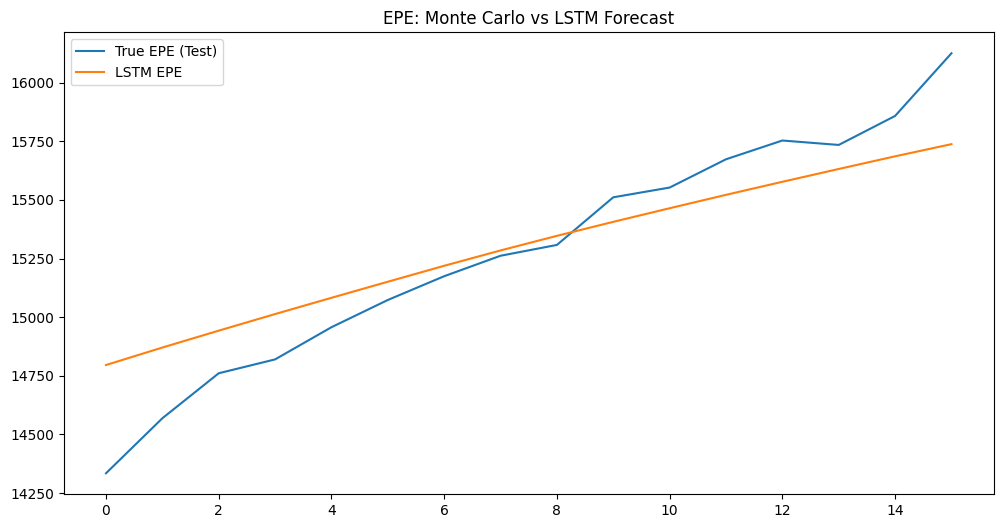

LSTM CVA: 31.03
Backtest MSE: 41450.118718


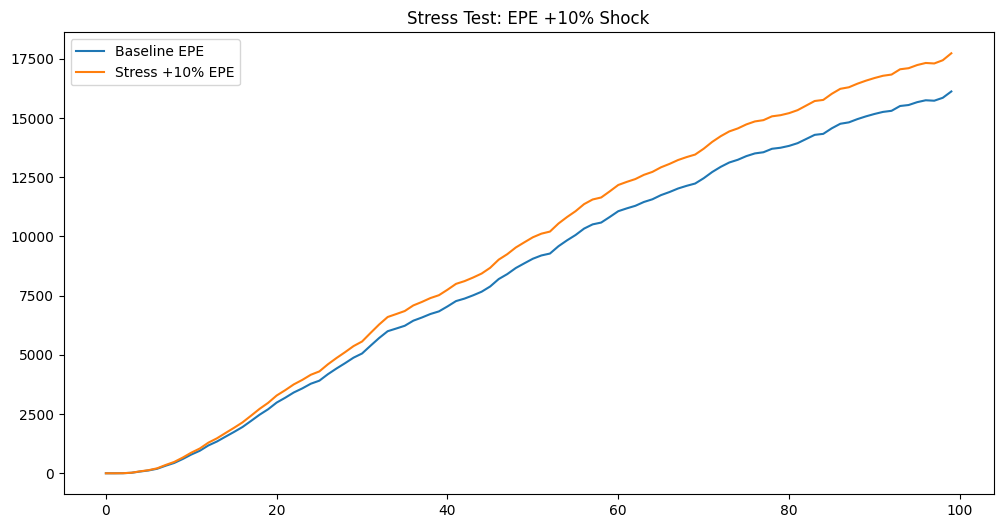

In [14]:
import numpy as np
import matplotlib.pyplot as plt


# === 2) Simulation parameters ===
S0 = 1.0
mu_fx = 0.0
sigma_fx = 0.1

r0 = 0.02
kappa_ir = 0.1
theta_ir = 0.02
sigma_ir = 0.01

lambda0 = 0.02
kappa_lambda = 0.3
theta_lambda = 0.02
sigma_lambda = 0.02

corr_matrix = np.array([
    [1.0, 0.2, 0.1],  # FX, IR, hazard
    [0.2, 1.0, 0.3],
    [0.1, 0.3, 1.0]
])

T = 1.0
dt = 0.01
Npaths = 5000

# === 3) Simulate risk factors ===
steps = int(T/dt)

fx_paths = simulate_gbm_fx(S0, mu_fx, sigma_fx, T, dt, Npaths)
ir_paths = simulate_hull_white(r0, kappa_ir, theta_ir, sigma_ir, T, dt, Npaths)
hazard_paths = simulate_cir_lambda(lambda0, kappa_lambda, theta_lambda, sigma_lambda, T, dt, Npaths)

# === 4) Correlate risk factors (for demonstration, simple independent here) ===
# (for more advanced: use your correlate.py with Cholesky)

# === 5) Build Portfolio ===
trades = [
    FXForward(notional=1e6, strike=1.05),
    IRSwap(notional=1e6, fixed_rate=0.02)
]
portfolio = Portfolio(trades)

# === 6) Calculate MtM, Netting, Collateral ===
fx_MtM = trades[0].MtM(fx_paths)
ir_MtM = trades[1].MtM(ir_paths)

portfolio_MtM = fx_MtM + ir_MtM

# Collateral: simple threshold
exposures = calculate_exposure(portfolio_MtM, collateral_threshold=100000)

# === 7) WWR: adjust hazard rate ===
hazard_rates_adj = apply_wrong_way_risk(hazard_paths, exposures)

# === 8) EPE ===
EPE_mc = expected_positive_exposure(exposures)

# === 9) Discount curve ===
DFs = discount_curve(ir_paths, dt)

# === 10) Baseline CVA ===
CVA_mc = calculate_cva(EPE_mc, hazard_rates_adj.mean(axis=1), LGD=0.6, discount_factors=DFs, dt=dt)
print(f"Baseline MC CVA: {CVA_mc:.2f}")

# === 11) Prepare LSTM dataset ===
scaler = MinMaxScaler()
EPE_scaled = scaler.fit_transform(EPE_mc.reshape(-1,1)).flatten()

timesteps = 20
X, y = [], []
for i in range(len(EPE_scaled) - timesteps):
    X.append(EPE_scaled[i:i+timesteps])
    y.append(EPE_scaled[i+timesteps])
X = np.array(X).reshape(-1, timesteps, 1)
y = np.array(y)

# === 12) Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# === 13) Build & train LSTM ===
model = build_stacked_lstm(timesteps, 1, units=100)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=200,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)

# === 14) Predict and inverse ===
y_pred_scaled = model.predict(X_test).flatten()
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

# === 15) Plot EPE: True vs LSTM ===
plt.figure(figsize=(12,6))
plt.plot(y_true, label="True EPE (Test)")
plt.plot(y_pred, label="LSTM EPE")
plt.title("EPE: Monte Carlo vs LSTM Forecast")
plt.legend()
plt.show()

# === 16) LSTM CVA ===
DFs_test = DFs[-len(y_true):]
hazard_test = hazard_rates_adj.mean(axis=1)[-len(y_true):]

CVA_lstm = calculate_cva(y_pred, hazard_test, LGD=0.6, discount_factors=DFs_test, dt=dt)
print(f"LSTM CVA: {CVA_lstm:.2f}")

# === 17) Backtest ===
mse = backtest(y_pred, y_true)
print(f"Backtest MSE: {mse:.6f}")

# === 18) Stress test ===
stressed_EPE = stress_test(EPE_mc, shock_factor=0.1)
plt.figure(figsize=(12,6))
plt.plot(EPE_mc, label="Baseline EPE")
plt.plot(stressed_EPE, label="Stress +10% EPE")
plt.title("Stress Test: EPE +10% Shock")
plt.legend()
plt.show()
